# Assignment 1 Stochastic Simulation: Area of the Mandelbrot set

#### Job Marcelis, 14000946

#### Ernani Hazbolatow, 14272210

#### Haitham Muhidin, 13970356

Below are the packeges that need to be installed in order for this code to run. If a CUDA environment is not present, all `CuPy` code can be converted to `NumPy` code by changing `cp` to `np`. Note that large sample sizes will be very slow with `NumPy`.

In [33]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cmath
from scipy.stats import qmc
from scipy.stats import pearsonr
import pandas as pd
dpi=300

To visualize the Mandelbrot set, we need some function that do calculations with complex numbers. Below are function to calculate the next iteration of the set and function to calculate the square, addition, and magnitude of complex numbers.

In [2]:
def mandelbrot(z, c):
    """Calculates the next iteration of the mandelbrot set according to z^2 + c.

    Args:
        z (float): complex coordinate of the current iteration
        c (float): complex coordinate of starting point

    Returns:
        float: coordinate of next iteration in the complex plane.
    """
    return add_complex(square_complex(z), c)

def square_complex(z):
    """Calculates the square of a complex number: (a + bi)^2

    Args:
        z (float): complex number

    Returns:
        float: square of a complex number
    """
    return complex(z.real**2 - z.imag**2, 2*z.real*z.imag)

def add_complex(z1, z2):
    """Adds two complex numbers: a+bi + c+di = a+b + (b+d)i

    Args:
        z1 (float): complex number 1
        z2 (float): complex number 2

    Returns:
        float: result of z1 + z2
    """
    return complex(z1.real + z2.real, z1.imag + z2.imag)

def magnitude_complex(z):
    """Calculates the magnitude of  a complex number: |z| = sqrt(a^2 + b^2)

    Args:
        z (float): complex number

    Returns:
        float: magnitude of z
    """
    return np.sqrt(z.real**2 + z.imag**2)

The diagram for the Mandelbrot set is made by iterating and keeping track of the number of iterations it takes for a point to diverge (if it diverges). The matrix that contains these values will be plotted with `imshow` from `matplotlib`.

In [ ]:
def mandelbrot_plot(resolution, max_length_set, re_min, re_max, im_min, im_max):
	"""For a given resolution and range of real and imaginary numbers, a matrix is generated based on the number of iterations it takes to diverge (or not).

	Args:
		resolution (int): number of points in the real and imaginary range
		max_length_set (int): maximum number of iterations per starting point
		re_min (float): start of real range
		re_max (float): end or real range
		im_min (float): start of imaginary range
		im_max (float): end of imaginary range

	Returns:
		ndarray: matrix to visualise the mandelbrot set
	"""	
	real_range = np.linspace(re_min, re_max, resolution)
	imaginary_range = np.linspace(im_min, im_max, resolution)
	mat = np.full((resolution, resolution), max_length_set)

	for i, im in enumerate(imaginary_range):
		for j, re in enumerate(real_range):
			c = complex(re, im)
			z = complex(0, 0)

			# checks after how many iteration the complex number diverges. if k=max_lengths_set, then no divergence.
			for k in range(max_length_set):
				z = mandelbrot(z, c)
				if magnitude_complex(z) > 2:
					mat[i, j] = k
					break

	return mat

In [5]:
mandelplot = mandelbrot_plot(resolution=1000, max_length_set=100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25)
mandelplot_zoom = mandelbrot_plot(resolution=1000, max_length_set=100, re_min=0.18, re_max=0.43, im_min=0.46, im_max=0.71)
mandelplot_zoom2 = mandelbrot_plot(resolution=1000, max_length_set=100, re_min=0.228, re_max=0.258, im_min=0.562, im_max=0.592)

C:\Users\JobMa\AppData\Local\Temp\ipykernel_23012\692084442.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0)


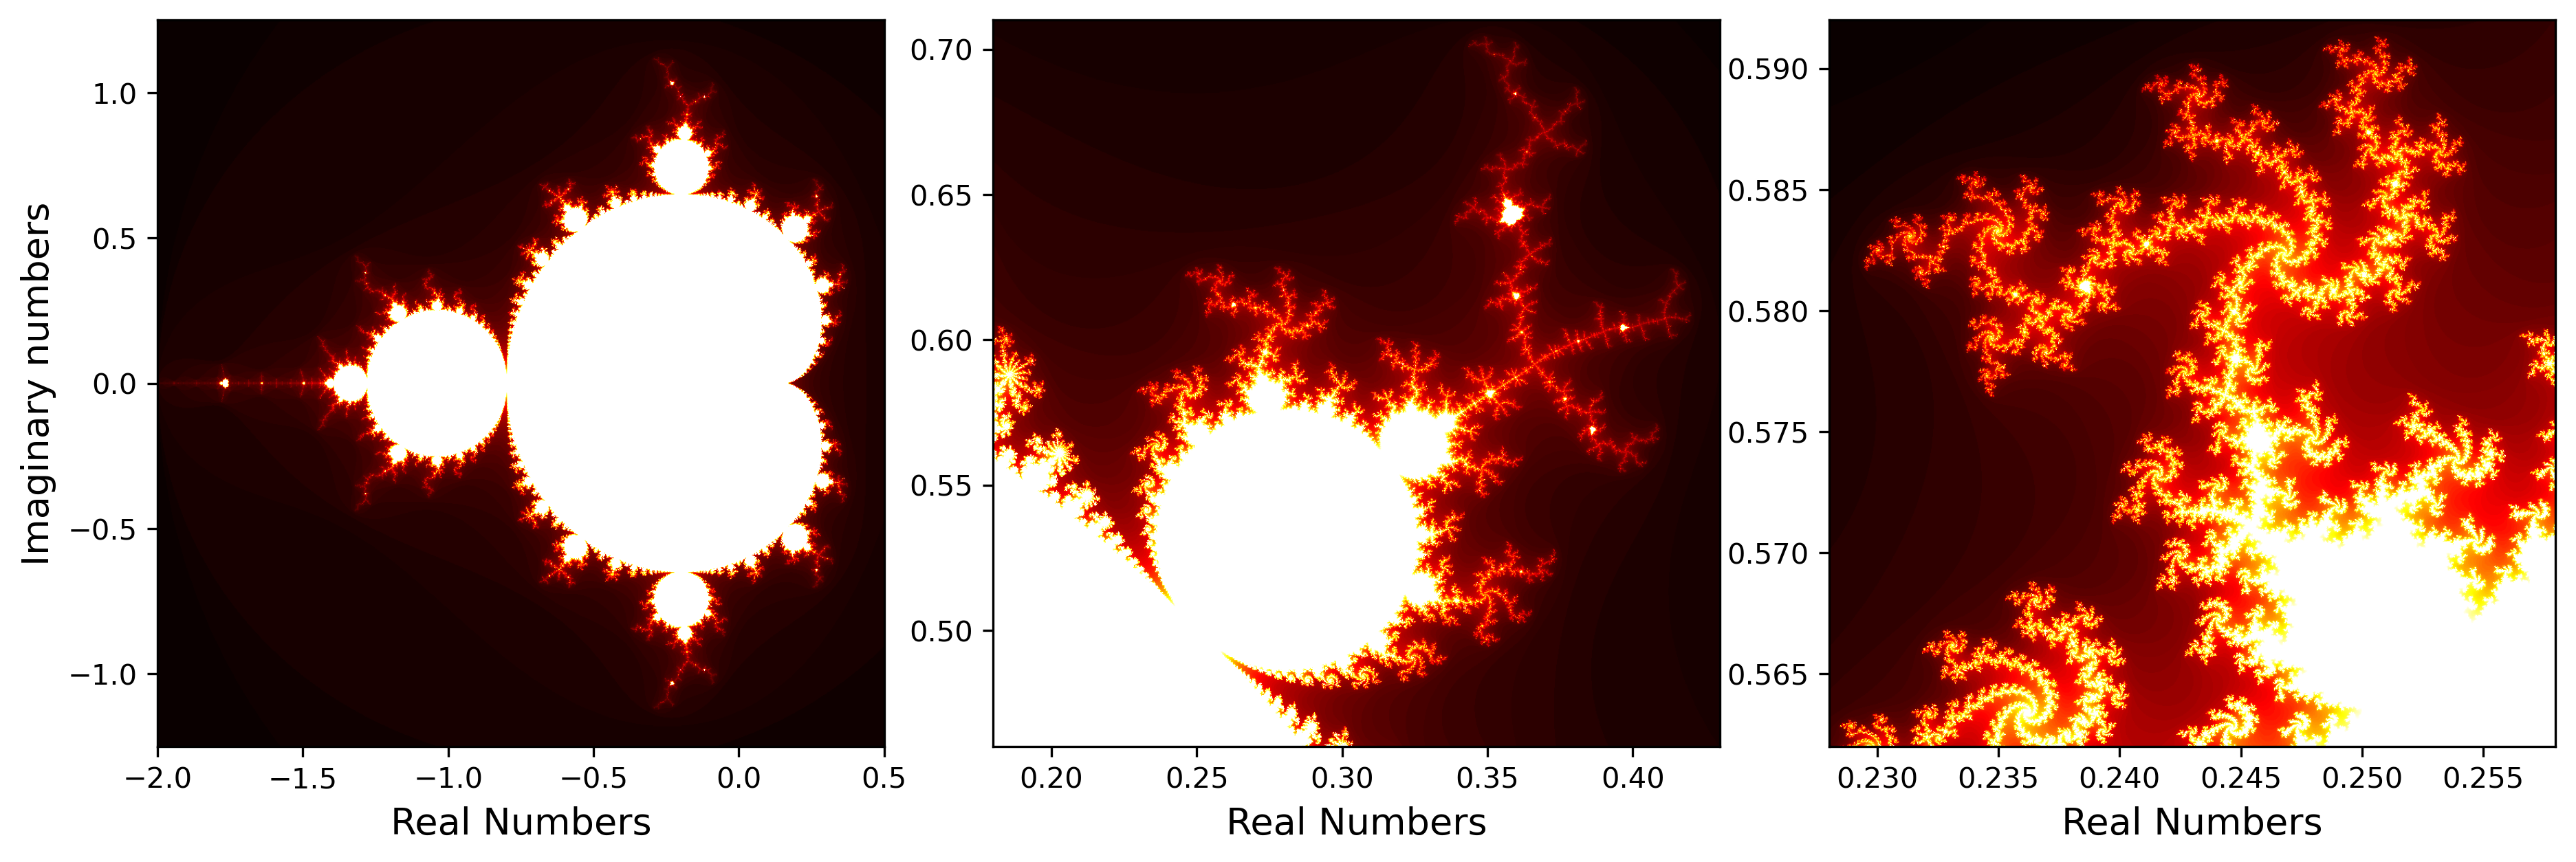

In [6]:
fig=  plt.figure(figsize=(15, 5), dpi=300)
gs = GridSpec(1, 3, fig, wspace=0.15, hspace=0.01)

# Main plot
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(mandelplot, cmap='hot', extent=[-2, 0.5, -1.25, 1.25])
ax1.set_ylabel('Imaginary numbers', fontsize=13)
ax1.set_xlabel('Real Numbers', fontsize=13)

# Zoom 1
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(mandelplot_zoom, cmap='hot', extent=[0.18, 0.43, 0.46, 0.71], origin='lower')
ax2.set_xlabel('Real Numbers', fontsize=13)

# Zoom 2
ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(mandelplot_zoom2, cmap='hot', extent=[0.228, 0.258, 0.562, 0.592], origin='lower')
ax3.set_xlabel('Real Numbers', fontsize=13)

plt.tight_layout(pad=1.0)
plt.show()

---


#### Mandelbrot Sampler
We implement four samplers to use for the Hit and Miss Integration:

1. **`UNIRAND`**:  
   This method performs uniform random sampling. It generates complex numbers by independently sampling the real and imaginary components uniformly within the specified bounds. This is suitable for simple, non-structured sampling across the domain.

2. **`LHC`**:  
   The Latin Hypercube Sampling method, similar to orthogonal sampling, divides the domain into regions for more systematic sampling. This method is particularly useful for reducing variance in the sampling process, resulting in a more even distribution across the bounds. 

3. **`OHC`**:  
   The Orthogonal Sampling method uses a Latin Hypercube with orthogonal sampling. This technique divides the domain into equally spaced regions, ensuring that each sample point falls into a unique orthogonal space, providing better coverage of the domain compared to simple random sampling. This sampling technique requires the square of prime numbers for the best results. To make a meaningful comparison, we also use the squared prime sampling for LHC and random.

4. **`SOBEL`**:  
   The Sobol Sampling method generates low-discrepancy points that cover the space more uniformly than purely random methods. Sobol sampling is particularly effective for high-dimensional spaces and requires the number of samples to be a power of two for optimal results. This method is often used for quasi-Monte Carlo simulations due to its efficiency in covering the domain.

In [9]:
class MBSampler:
    """
    A class used to sample points of the mandelbrot set for montecarlo sampling

    Attributes
    ----------
    re_min : float
        The lower bound of the real axis of the mandelbrot set
    re_max : float
        The upper bound of the real axis of the mandelbrot set
    im_min : float
        The lower bound of the imaginary axis of the mandelbrot set
    im_max : float
        The upper bound of the imaginary axis of the mandelbrot set

    Methods
    -------
    sample(method, num_samples, seed):
        Generates an given amount of complex numbers using a specified method that will use the seed given
    uniform_random(num_samples, seed):
        Generates an given amount of complex numbers using uniform random sampling with the given seed
    orthogonal(num_samples, seed):
        Generates an given amount of complex numbers using orthogonal sampling with the given seed
    latin_hypercube(num_samples, seed):
        Generates an given amount of complex numbers using orthogonal sampling with the given seed
    sobol(num_samples, seed):
        Generates an given amount of complex numbers using orthogonal sampling with the given seed
    """
    def __init__(self, re_min, re_max, im_min, im_max):
        self.bounds = {
            "re_min": re_min,
            "re_max": re_max,
            "im_min": im_min,
            "im_max": im_max
        }

    def sample(self, method, num_samples, seed):
        match method:
            case "UNIRAND":
                return self.uniform_random(num_samples, seed)
            case "OHC":
                return self.orthogonal(num_samples, seed)
            case "LHC":
                return self.latin_hypercube(num_samples, seed)
            case "SOBEL":
                return self.sobol(num_samples, seed)
            case _:
                raise ValueError("Unknown Sampling Method")

    def uniform_random(self, num_samples, seed):
        np.random.seed(seed)
        c_re = np.random.uniform(self.bounds["re_min"], self.bounds["re_max"], num_samples)
        c_im = np.random.uniform(self.bounds["im_min"], self.bounds["im_max"], num_samples)
        c_array = c_re + 1j * c_im
        return c_array, c_re, c_im

    def _scaled_sampling(self, sampler, num_samples):
        samples = sampler.random(n=num_samples)
        scaled_samples = qmc.scale(samples,
                                   [self.bounds["re_min"], self.bounds["im_min"]],
                                   [self.bounds["re_max"], self.bounds["im_max"]])
        c_re = scaled_samples[:, 0]
        c_im = scaled_samples[:, 1]
        c_array = c_re + 1j * c_im
        return c_array, c_re, c_im

    def orthogonal(self, num_samples, seed):
        orth = qmc.LatinHypercube(d=2, strength=2, seed=seed)
        return self._scaled_sampling(orth, num_samples)

    def latin_hypercube(self, num_samples, seed):
        lhc = qmc.LatinHypercube(d=2, seed=seed)
        return self._scaled_sampling(lhc, num_samples)

    def sobol(self, num_samples, seed):
        if not (num_samples and (num_samples & (num_samples - 1)) == 0):
            raise ValueError("For Sobol sampling, num_samples must be a power of 2.")
        sobol = qmc.Sobol(d=2, seed=seed)
        return self._scaled_sampling(sobol, num_samples)

Since Sobol sampling uses powers of 2, we created a function that creates all powers of 2 up to a given power.

In [10]:
def sobol_sample_sizes_generator(power=10):
    """Generates a list of the first 10 allowed numbers to be used for sobol sampling which are a power of 2.

    Args:
        power (int, optional): the highest power of 2 to be sampled from. Defaults to 10.

    Returns:
        list of int: a list of numbers from 2 to 2**power.
    """
    return [2**n for n in range(1,power+1)]

---

To visualize the differences between the four sampling techniques, we plot roughly 120 points, 121 for the prime sampling (Random, LHS, Orthogonal) and 128 for the Sobol sampling

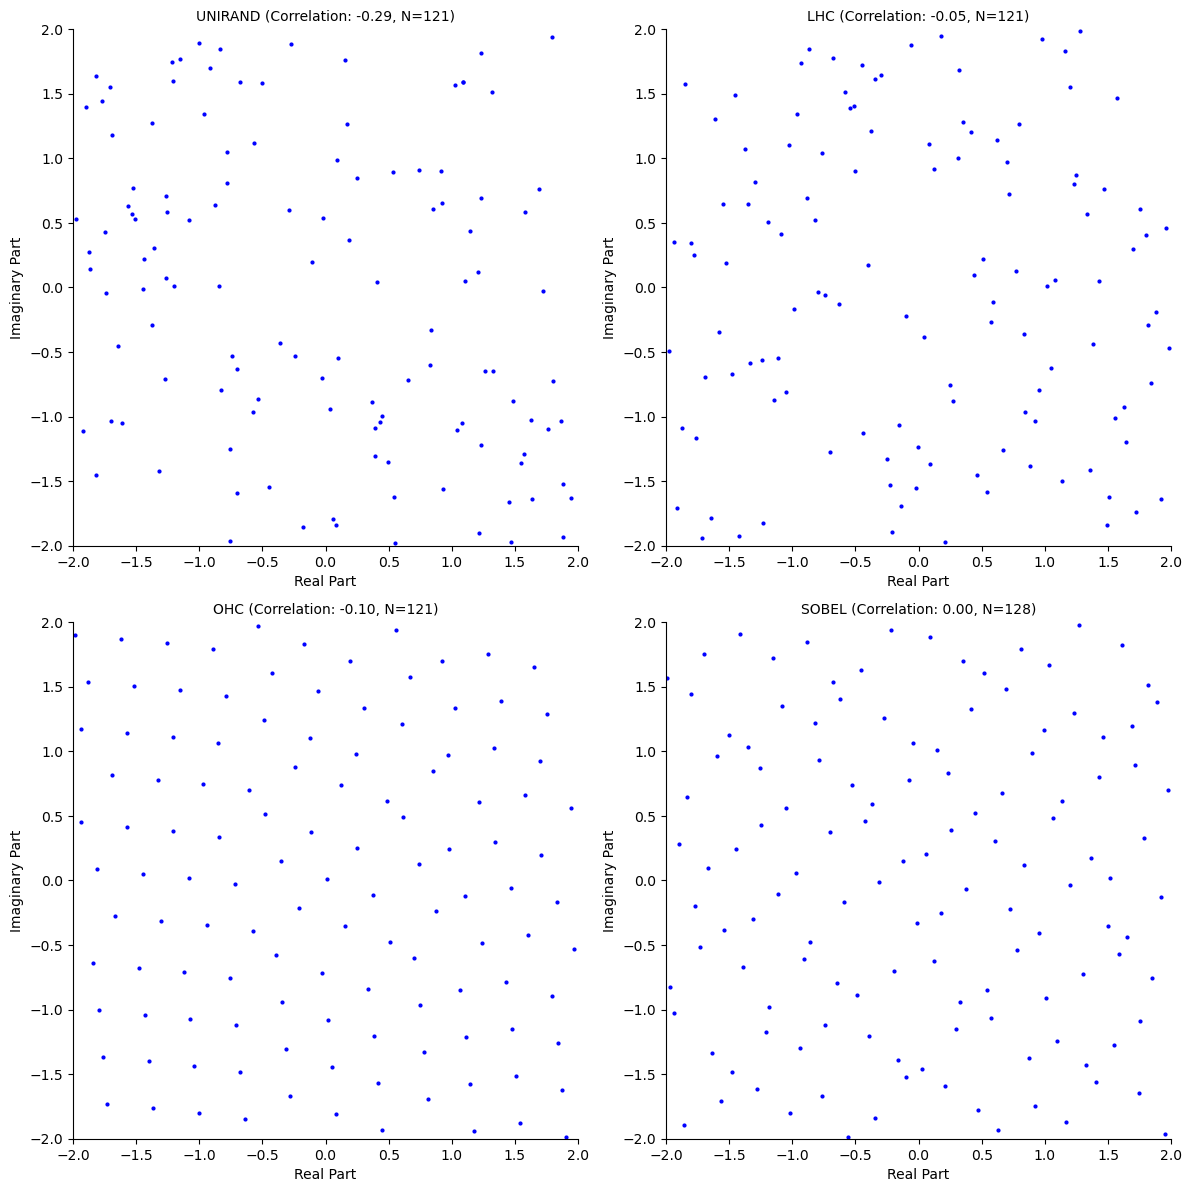

In [13]:
# Initialize MBSampler instance with desired bounds
sampler = MBSampler(re_min=-2, re_max=2, im_min=-2, im_max=2)
num_samples = {
    "UNIRAND": 121,
    "OHC": 121,
    "LHC": 121,
    "SOBEL": 128
}
seed = 42  # Random seed for reproducibility

# Sampling methods to test
methods = ["UNIRAND", "LHC", "OHC", "SOBEL"]
correlations = {}
samples = {}

# Generate samples and calculate correlations
for method in methods:
    c_array, c_re, c_im = sampler.sample(method, num_samples[method], seed)
    corr, _ = pearsonr(c_re, c_im)
    correlations[method] = corr
    samples[method] = (c_re, c_im)

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()

for i, method in enumerate(methods):
    c_re, c_im = samples[method]
    correlation = correlations[method]
    axs[i].scatter(c_re, c_im, s=4, color='blue')
    axs[i].set_title(f"{method} (Correlation: {correlation:.2f}, N={num_samples[method]})", fontsize=10)
    axs[i].set_xlabel("Real Part")
    axs[i].set_ylabel("Imaginary Part")
    axs[i].set_xlim([-2, 2])
    axs[i].set_ylim([-2, 2])

    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

plt.tight_layout(pad=1.0, h_pad=1.0, w_pad=1.0)  # Reduces padding between plots
plt.show()

---

The two function below perform the Monte Carlo integration for different sample sizes and iterations. Using `CuPy` the samples are evaluated in parallel and the values are extracted using `.get()`.

In [14]:
def iterate_mandelbrot(c, max_set_length):
    """Iterate over the Mandelbrot set for a given number of iterations.

    Args:
        c (float): sample as complex number
        max_set_length (int): maximum number of iterations

    Returns:
        float: result of the iterations
    """    
    z = 0
    for i in range(max_set_length):
        z = z * z + c
    return z

In [20]:
def monte_carlo(sample_range, num_iterations, max_length_set, re_min, re_max, im_min, im_max, sampling_method, seed_scramble):
    """Perform Monte Carlo integration for different sample sizes and number of iterations.

    Args:
        sample_range (array): array of sample sizes, each sample size gets evaluted num_iterations times
        num_iterations (int): number of iterations for each sample size
        max_length_set (int): maximum number of iterations
        re_min (float): start of the real range
        re_max (float): end of the real range
        im_min (float): start of the imaginary range
        im_max (float): end of the imaginary range
        sampling_method (str): sampling method 
        seed_scramble (int): seed

    Returns:
        array: 2 dimensional array, each column is a different sample size and each row a different iteration
    """    
    all_iterations = cp.zeros((num_iterations, len(sample_range)))
    area_integration_box = cp.abs(re_max - re_min) * cp.abs(im_max - im_min)
    sampler = MBSampler(re_min=re_min, re_max=re_max, im_min=im_min, im_max=im_max)

    for l, n_samples in enumerate(sample_range):
        areas = cp.zeros(num_iterations)
        print(f'Current Sample size: {n_samples}')
        for i in range(num_iterations):
            c_array, c_re, c_im = sampler.sample(method=sampling_method, num_samples=n_samples, seed=i + seed_scramble)

            set = cp.array(iterate_mandelbrot(c_array, max_length_set))
            set = set[~cp.isnan(set)]
            set = set[cp.abs(set) < 2]

            areas[i] = area_integration_box * len(set) / n_samples

        all_iterations[:, l] = areas

    return all_iterations.get()

To understand how many iterations are sufficient to obtain an accurate result, we create a baseline measurement at 5000 iterations and a constant sample size of 961 (prime sampling) and 1024 (sobol sampling). We denote this with $A_{5000, 1000}$. 

In [16]:
random_baseline = np.mean(monte_carlo([961], 5000, 1000, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='UNIRAND', seed_scramble=100)[:, -1])
LHC_baseline = np.mean(monte_carlo([961], 5000, 1000, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='LHC',seed_scramble=100)[:,-1])
OS_baseline = np.mean(monte_carlo([961], 5000, 1000, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='OHC', seed_scramble=100)[:, -1])
sobol_baseline = np.mean(monte_carlo([1024], 5000, 1000, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='SOBEL',seed_scramble=100)[:, -1])

C:\Users\JobMa\AppData\Local\Temp\ipykernel_23012\4130297354.py:13: RuntimeWarning: overflow encountered in multiply
  z = z * z + c
C:\Users\JobMa\AppData\Local\Temp\ipykernel_23012\4130297354.py:13: RuntimeWarning: invalid value encountered in multiply
  z = z * z + c


We now compare a lower number of iterations $j$ at the same sample size. Calculating $A_{j, 1000} - A_{5000, 1000}$ gives insight in how many iterations are needed. 

In [ ]:
iteration_range = [10, 25, 50, 75, 100, 150, 200, 300, 400, 500, 750, 1000, 1500, 2000, 2500, 3000]

def calculate_difference(baseline, method):
    """Calculates the difference between the baseline at 5000 iterations and the value of the area for j iterations, where j < 5000.

    Args:
        baseline (float): area for ~1000 samples and 5000 iterations.
        method (str): sampling method

    Returns:
        list: differences between 5000 iterations and j iterations (j < 5000).
    """    
    deltas = []

    for i in iteration_range:
        if method == 'SOBEL':
            area_j = np.mean(monte_carlo([1024], i, 1000, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method=method, seed_scramble=100)[:, -1])
        else:
            area_j = np.mean(monte_carlo([961], i, 1000, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method=method, seed_scramble=100)[:, -1])

        delta = area_j - baseline
        deltas.append(delta)
    return deltas

In [18]:
deltas_random = calculate_difference(random_baseline, 'UNIRAND')
print('Start LHS')
deltas_LHC = calculate_difference(LHC_baseline, 'LHC')
print('Start OS')
deltas_OS = calculate_difference(OS_baseline, 'OHC')
print('Start Sobol')
deltas_sobol = calculate_difference(sobol_baseline, 'SOBEL')

C:\Users\JobMa\AppData\Local\Temp\ipykernel_23012\4130297354.py:13: RuntimeWarning: overflow encountered in multiply
  z = z * z + c
C:\Users\JobMa\AppData\Local\Temp\ipykernel_23012\4130297354.py:13: RuntimeWarning: invalid value encountered in multiply
  z = z * z + c


Start LHS
Start OS
Start Sobol


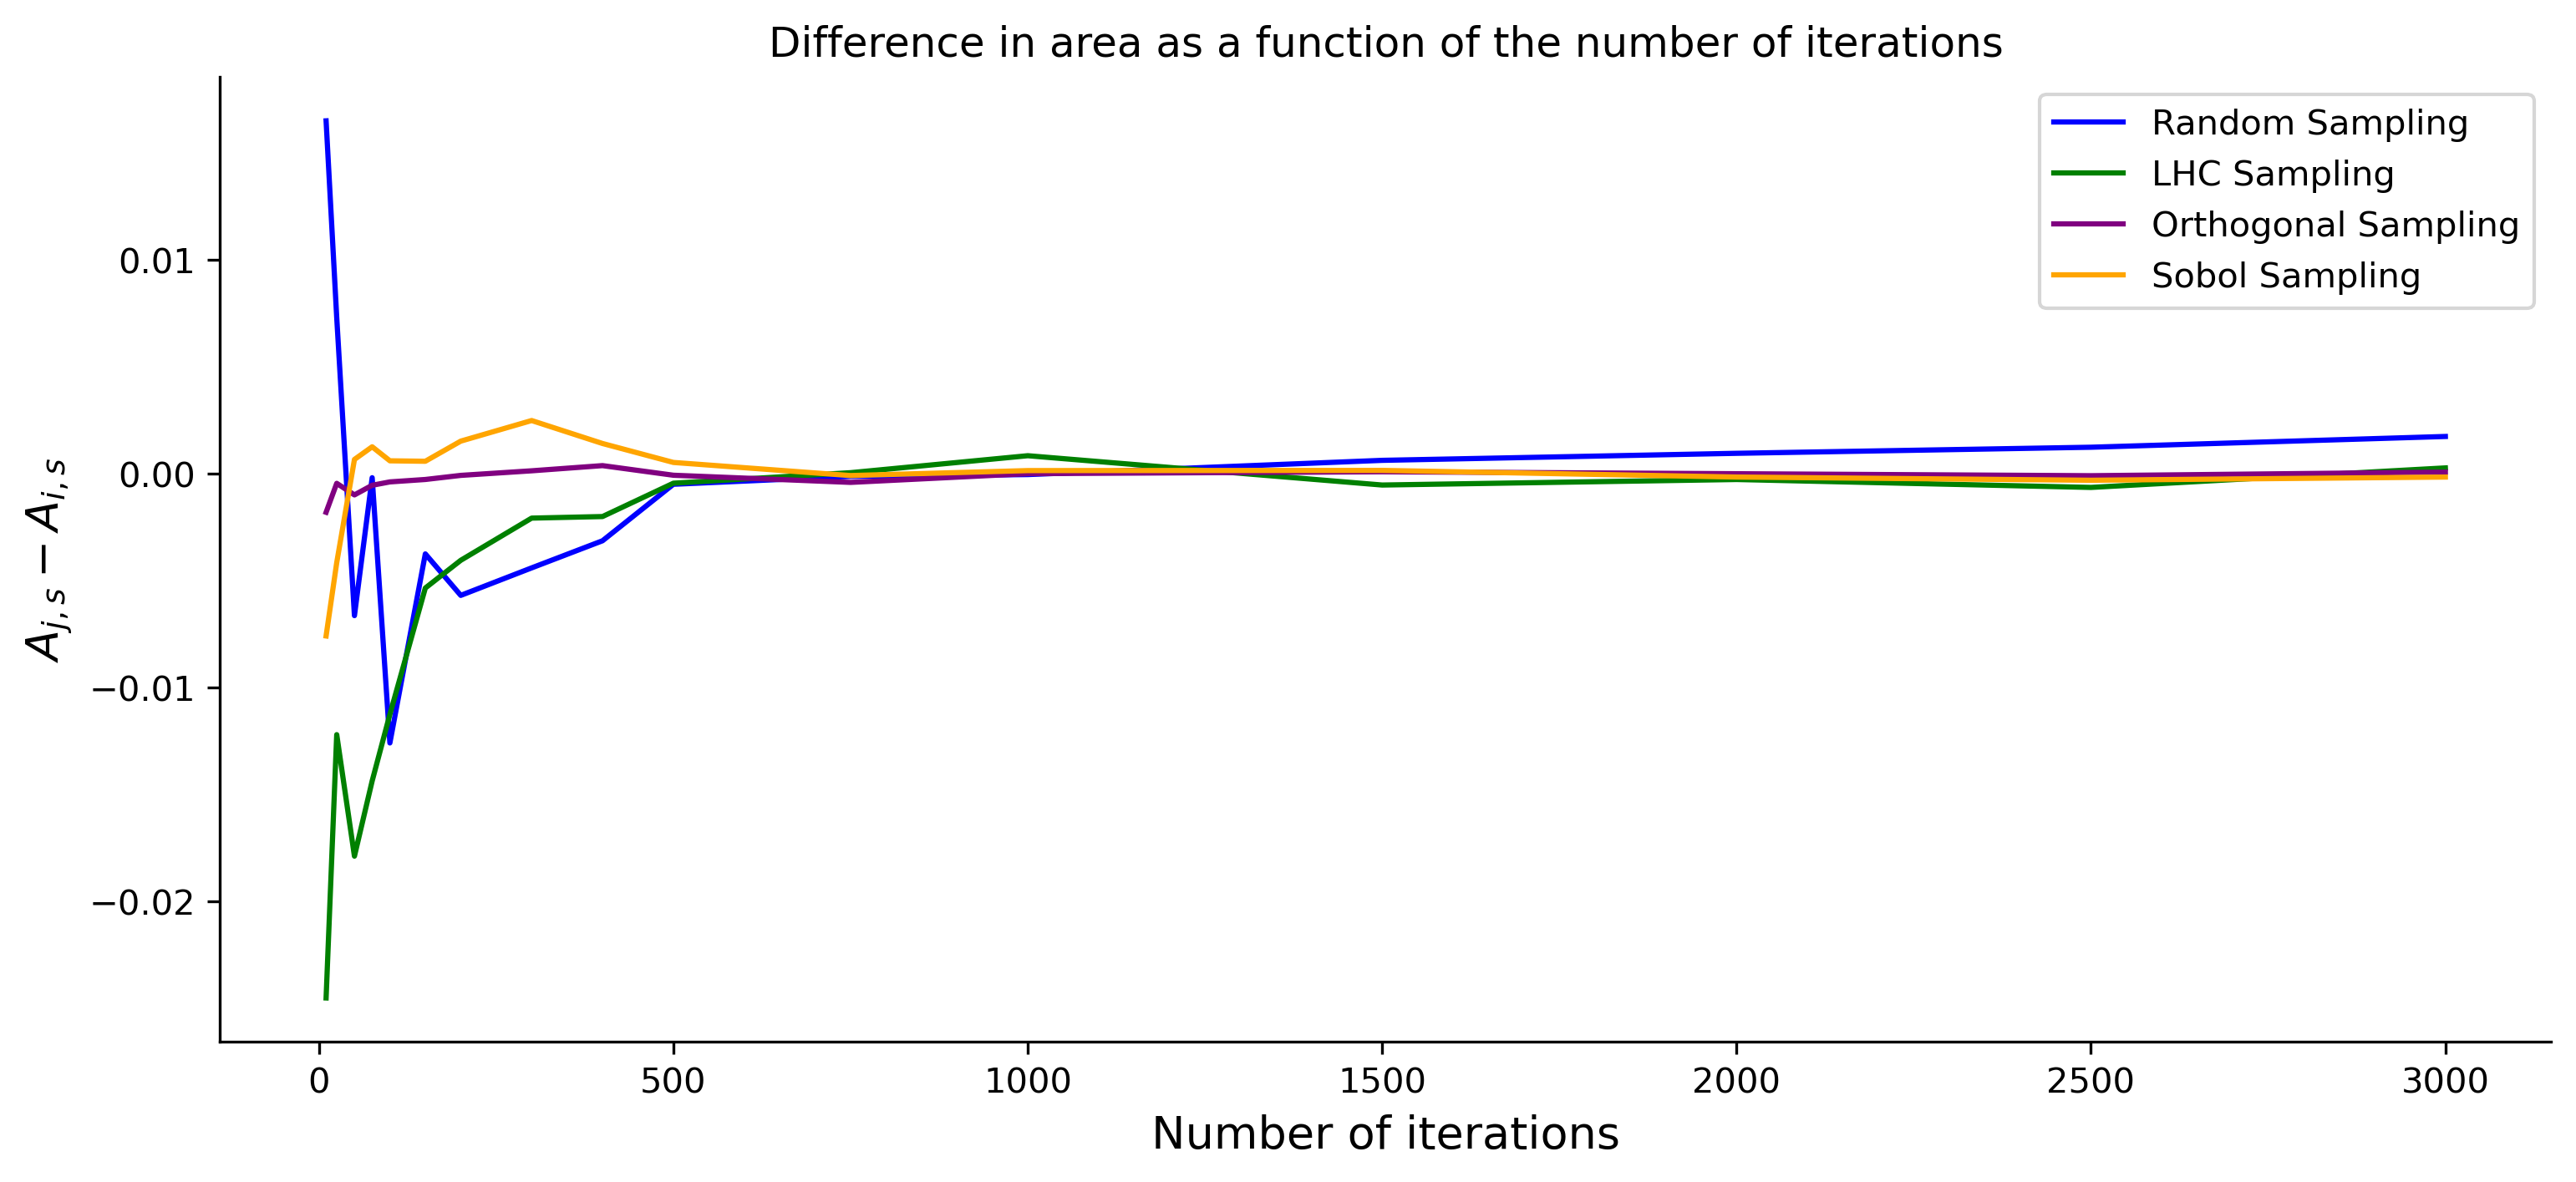

In [19]:
plt.figure(figsize=(12, 5), dpi=300)

plt.plot(iteration_range, deltas_random, color='blue', label='Random Sampling')
plt.plot(iteration_range, deltas_LHC, color='green', label='LHC Sampling')
plt.plot(iteration_range, deltas_OS, color='purple', label='Orthogonal Sampling')
plt.plot(iteration_range, deltas_sobol, color='orange', label='Sobol Sampling')
plt.xlabel('Number of iterations', fontsize=13)
plt.ylabel(r'$A_{j,s} - A_{i, s}$', fontsize=13)
plt.title('Difference in area as a function of the number of iterations')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend()
plt.show()

With the above results in mind, we will use 500 iterations for following results to keep the accuracy as high as possible while saving substantial computation time compared to 5000 iterations.

---

We now estimate the Area of the Mandelbrot set $A_M$ by increasing the number of samples from 4 to 32761 (prime sampling) and from 2 to 32768 (sobol sampling). Note that this cell takes approximately 1.5 hours

In [ ]:
# Square of primes: 181**2 = 32761 samples, 2**15 = 32761 samples
sample_range = np.array([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 67, 89, 107, 137, 181])**2
sobol_sample = sobol_sample_sizes_generator(15)

random = monte_carlo(sample_range, 500, 1000, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='UNIRAND', seed_scramble=100)
print('Start LHC')
LHC = monte_carlo(sample_range, 500, 1000, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='LHC',seed_scramble=100)
print('Start OS')
OS = monte_carlo(sample_range, 500, 1000, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='OHC', seed_scramble=100)
print('Start Sobol')
sobol = monte_carlo(sobol_sample, 500, 1000, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='SOBEL',seed_scramble=100)

Current Sample size: 4


C:\Users\JobMa\AppData\Local\Temp\ipykernel_23012\4130297354.py:13: RuntimeWarning: overflow encountered in multiply
  z = z * z + c
C:\Users\JobMa\AppData\Local\Temp\ipykernel_23012\4130297354.py:13: RuntimeWarning: invalid value encountered in multiply
  z = z * z + c


Current Sample size: 9
Current Sample size: 25
Current Sample size: 49
Current Sample size: 121
Current Sample size: 169
Current Sample size: 289
Current Sample size: 361
Current Sample size: 529
Current Sample size: 841
Current Sample size: 961
Current Sample size: 1369
Current Sample size: 4489
Current Sample size: 7921
Current Sample size: 11449
Current Sample size: 18769
Current Sample size: 32761
Start LHC
Current Sample size: 4
Current Sample size: 9
Current Sample size: 25
Current Sample size: 49
Current Sample size: 121
Current Sample size: 169
Current Sample size: 289
Current Sample size: 361
Current Sample size: 529
Current Sample size: 841
Current Sample size: 961
Current Sample size: 1369
Current Sample size: 4489
Current Sample size: 7921
Current Sample size: 11449
Current Sample size: 18769
Current Sample size: 32761
Start OS
Current Sample size: 4
Current Sample size: 9
Current Sample size: 25
Current Sample size: 49
Current Sample size: 121
Current Sample size: 169
Curr

We calculate the mean from the 500 iterations and plot it together with the error. In this case, the error is the confidence interval at the $p=95\%$ confidence level. Furthermore, the highest precision estimate is mentioned in the label of each plot.

Random: mean=1.5100828729281768 +- 0.0013298779295806728
LHC: mean=1.5102110436189373 +- 0.0008817096006150844
Ortho: mean=1.5104626232410487 +- 0.0001581909495934076
Sobol: mean=1.510234375 +- 0.0001779524795506454


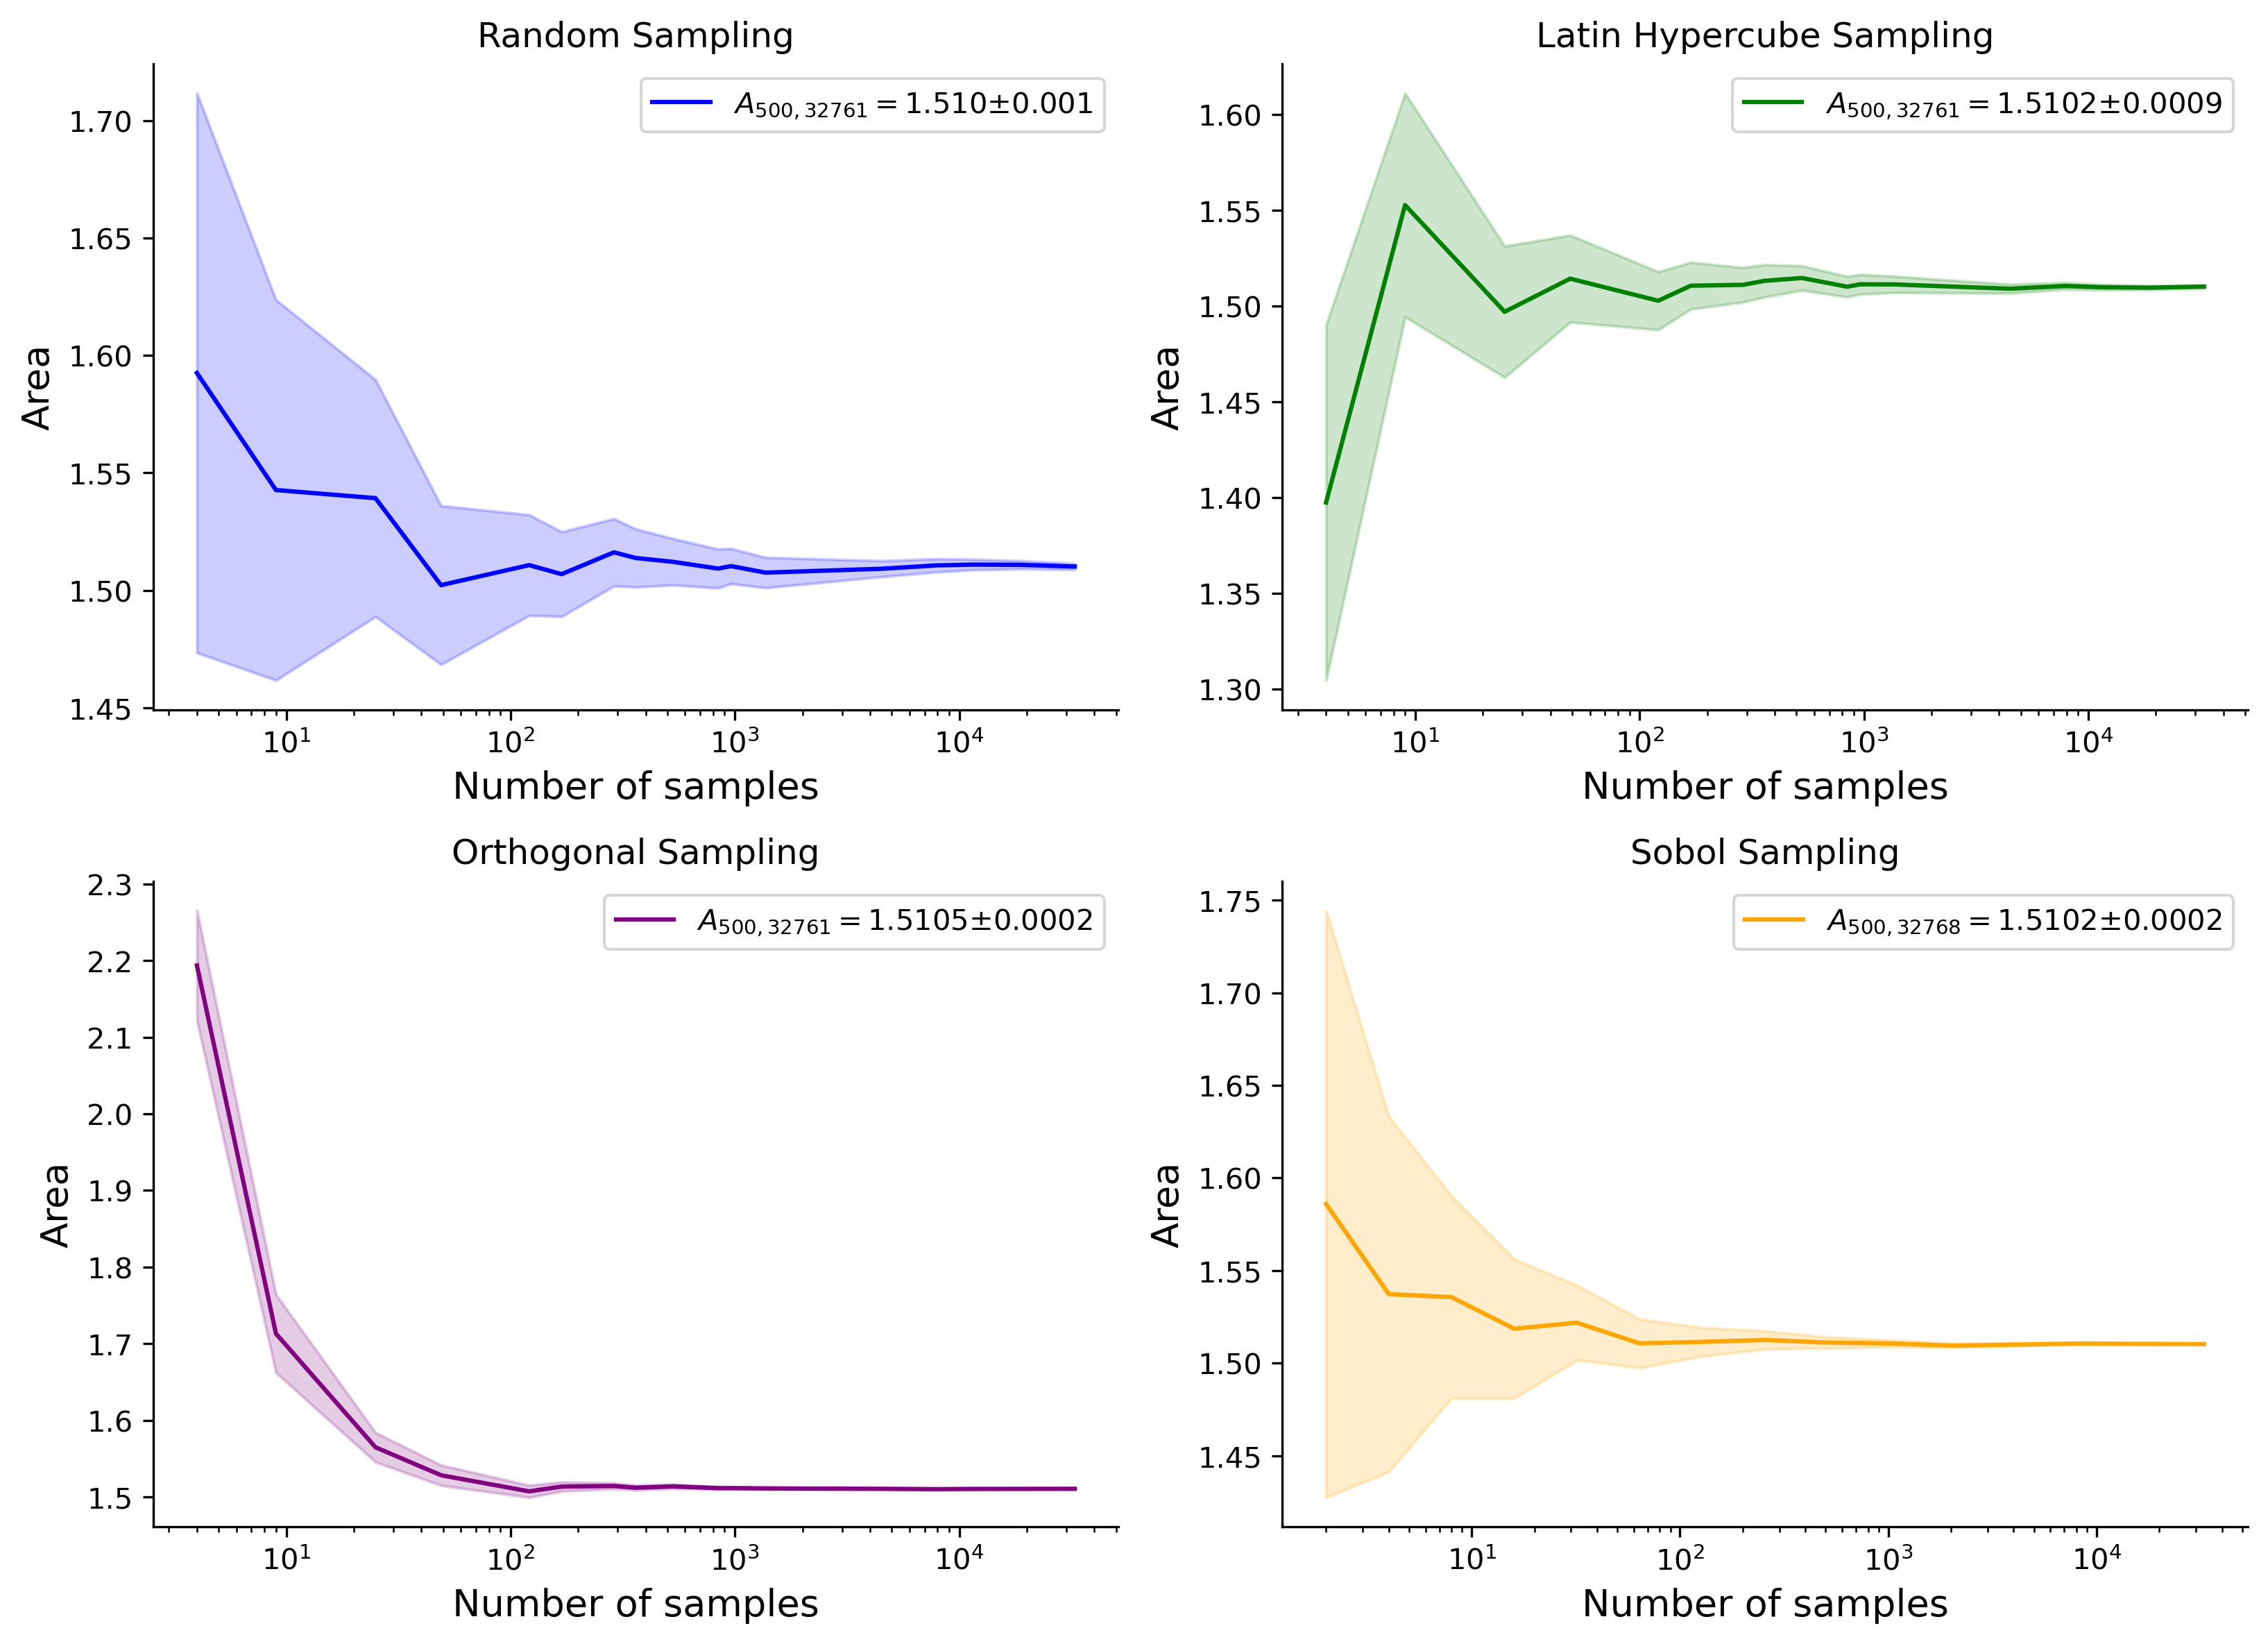

In [37]:
# Calculate means and standard errors for each sampling method
mean_area_random = np.mean(random[:, -1])
mean_random = np.mean(random, axis=0)
std_error_random = 1.96*np.std(random, axis=0) / np.sqrt(random.shape[0])
print(f'Random: mean={mean_area_random} +- {std_error_random[-1]}')

mean_area_LHC = np.mean(LHC[:, -1])
mean_LHC = np.mean(LHC, axis=0)
std_error_LHC = 1.96*np.std(LHC, axis=0) / np.sqrt(LHC.shape[0])
print(f'LHC: mean={mean_area_LHC} +- {std_error_LHC[-1]}')

mean_area_OS = np.mean(OS[:, -1])
mean_OS = np.mean(OS, axis=0)
std_error_OS = 1.96*np.std(OS, axis=0) / np.sqrt(OS.shape[0])
print(f'Ortho: mean={mean_area_OS} +- {std_error_OS[-1]}')

mean_area_SOBOL = np.mean(sobol[:, -1])
mean_sobol = np.mean(sobol, axis=0)
std_error_sobol = 1.96*np.std(sobol, axis=0) / np.sqrt(sobol.shape[0])
print(f'Sobol: mean={mean_area_SOBOL} +- {std_error_sobol[-1]}')

plt.figure(figsize=(11, 8), dpi=300)

# Random Sampling
plt.subplot(2, 2, 1)
plt.title('Random Sampling')
plt.plot(sample_range, mean_random, color='blue', label=fr'$A_{{500,32761}} = {round(mean_area_random, 3)}0 ± {round(std_error_random[-1], 3)}$')
plt.fill_between(sample_range, mean_random - std_error_random, mean_random + std_error_random, color='blue', alpha=0.2)
plt.xlabel('Number of samples', fontsize=13)
plt.ylabel('Area', fontsize=13)
plt.legend()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xscale('log')

# Latin Hypercube Sampling
plt.subplot(2, 2, 2)
plt.title('Latin Hypercube Sampling')
plt.plot(sample_range, mean_LHC, color='green', label=fr'$A_{{500,32761}} = {round(mean_area_LHC, 4)} ± {round(std_error_LHC[-1], 4)}$')
plt.fill_between(sample_range, mean_LHC - std_error_LHC, mean_LHC + std_error_LHC, color='green', alpha=0.2)
plt.xlabel('Number of samples', fontsize=13)
plt.ylabel('Area', fontsize=13)
plt.legend()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xscale('log')

# Orthogonal Sampling
plt.subplot(2, 2, 3)
plt.title('Orthogonal Sampling')
plt.plot(sample_range, mean_OS, color='purple', label=fr'$A_{{500,32761}} = {round(mean_area_OS, 4)} ± {round(std_error_OS[-1], 4)}$')
plt.fill_between(sample_range, mean_OS - std_error_OS, mean_OS + std_error_OS, color='purple', alpha=0.2)
plt.xlabel('Number of samples', fontsize=13)
plt.ylabel('Area', fontsize=13)
plt.legend()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xscale('log')

# Sobol Sampling
plt.subplot(2, 2, 4)
plt.title('Sobol Sampling')
plt.plot(sobol_sample, mean_sobol, color='orange', label=fr'$A_{{500,32768}} = {round(mean_area_SOBOL, 4)} ± {round(std_error_sobol[-1],4)}$')
plt.fill_between(sobol_sample, mean_sobol - std_error_sobol, mean_sobol + std_error_sobol, color='orange', alpha=0.2)
plt.xlabel('Number of samples', fontsize=13)
plt.ylabel('Area', fontsize=13)
plt.legend()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xscale('log')

plt.tight_layout()
plt.show()

Since the above results take roughly 1.5 hours to complete. We write the data to a csv file in case it gets lost:

In [ ]:
df_area = pd.DataFrame({
    'Random_mean': mean_random,
    'Random_error': std_error_random,
    'LHC_mean': mean_LHC,
    'LHC_error': std_error_LHC,
    'OS_mean': mean_OS,
    'OS_error': std_error_OS,
})
# Sobol arrays have a slightly different lengths compared to the rest and thus need their own data frame.
df_area_sobol = pd.DataFrame({
    'Sobol_mean': mean_sobol,
    'Sobol_error': std_error_sobol
})
df_area_combined = pd.concat([df_area, df_area_sobol])
df_area_combined.to_csv('Area_data.csv', index=False)

We now want to compare our results to the literature. A paper by Förstemann from 2012 estimated the area of the Mandelbrot set with very high precision, which resulted in $A_M = 1.5065918849 \pm 0.0000000028$. Below we plot this result along with our own results.

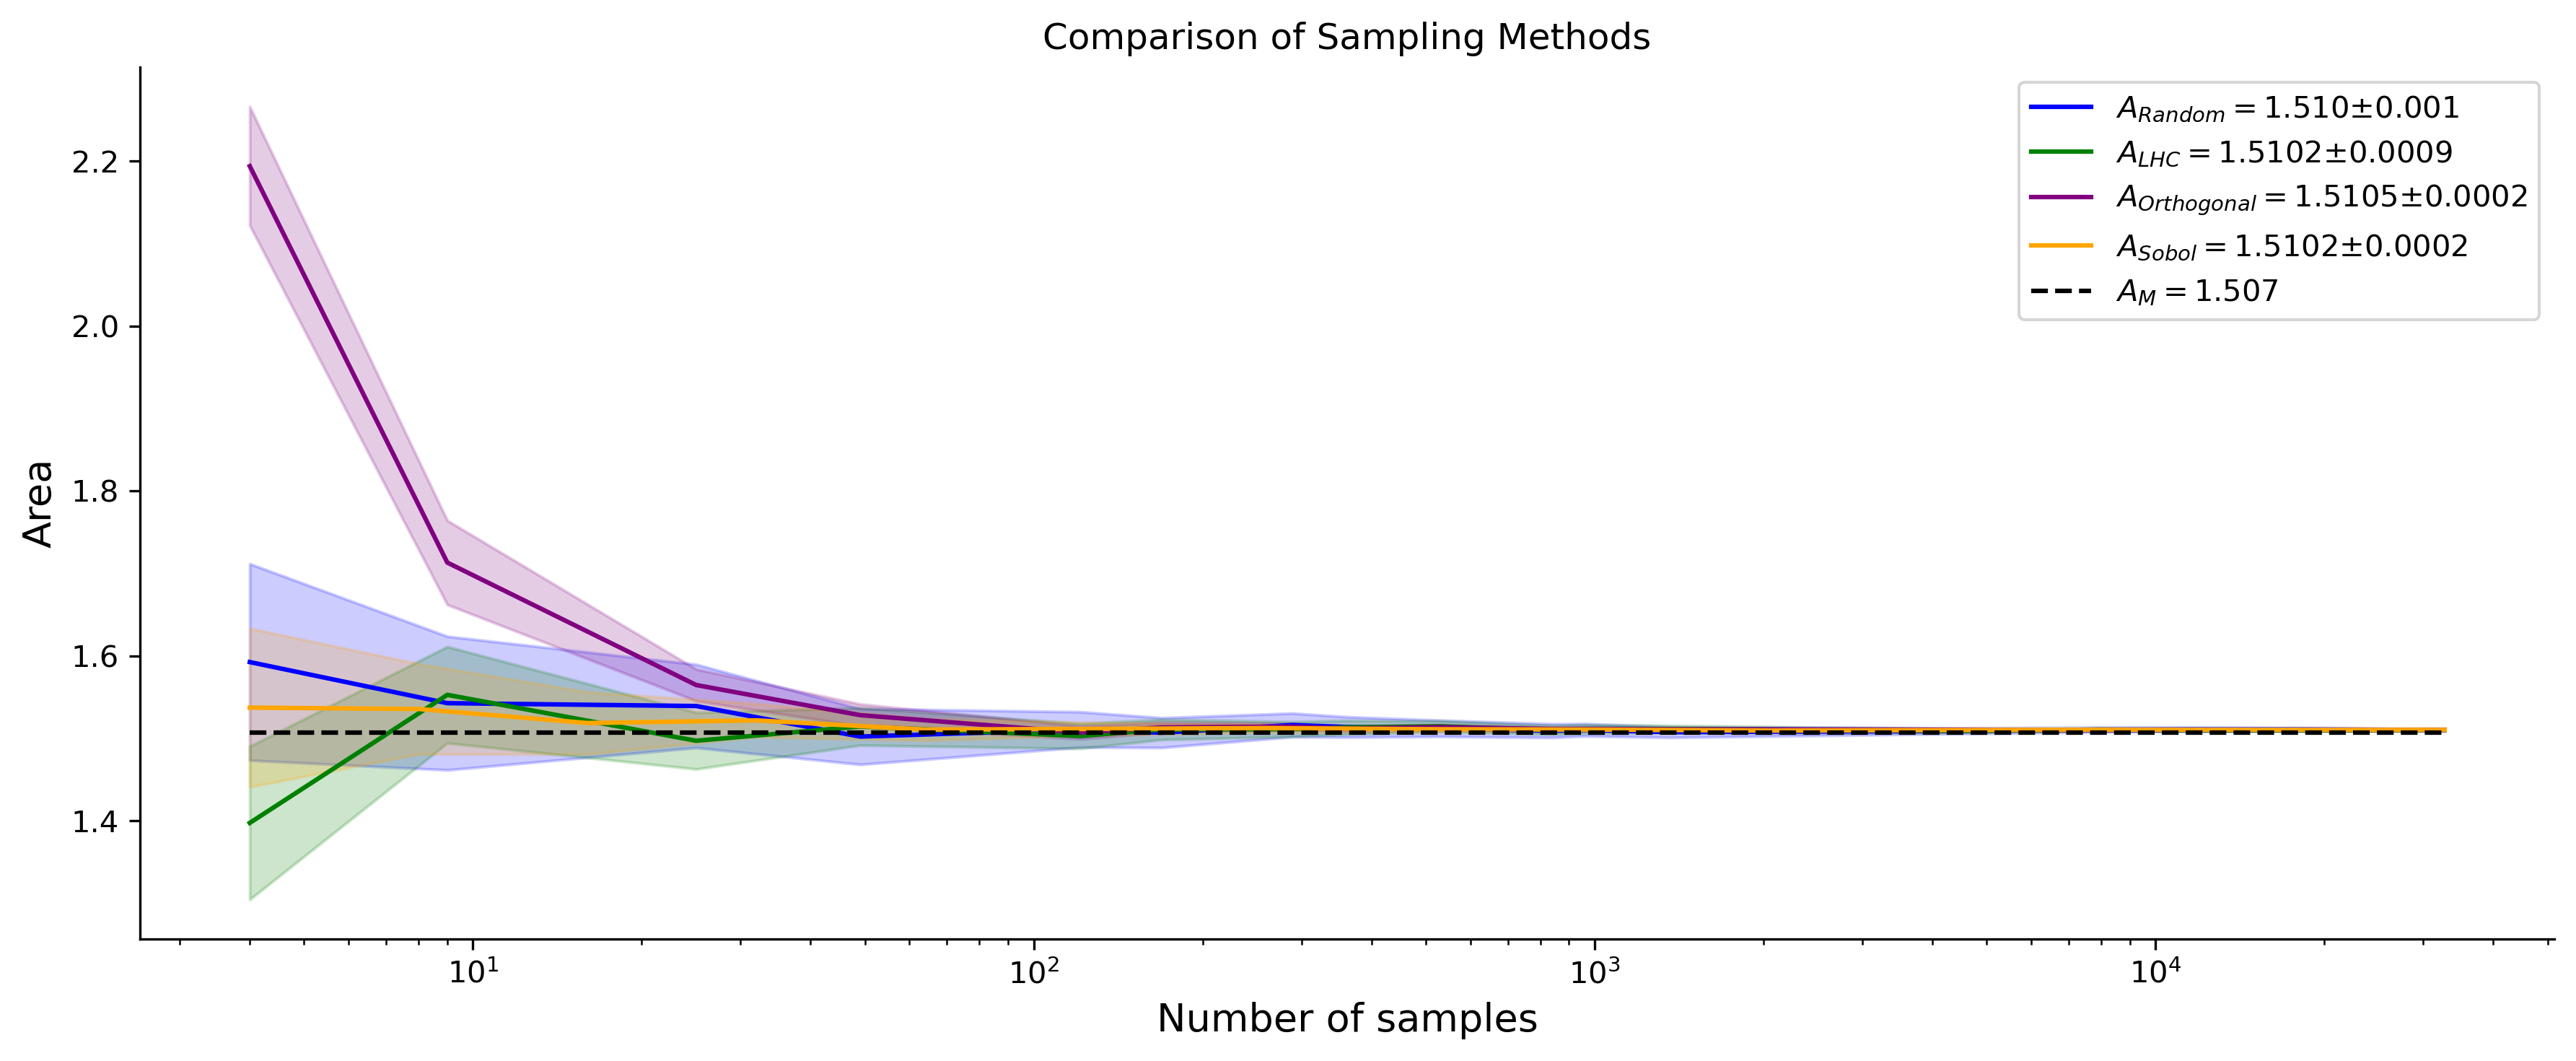

In [38]:
# Plot all in one figure
plt.figure(figsize=(12, 5), dpi=300)

# Random Sampling
plt.plot(sample_range, mean_random, color='blue', label=fr'$A_{{Random}} = {round(mean_area_random, 3)}0 ± {round(std_error_random[-1], 3)}$')
plt.fill_between(sample_range, mean_random - std_error_random, mean_random + std_error_random, color='blue', alpha=0.2)

# Latin Hypercube Sampling
plt.plot(sample_range, mean_LHC, color='green', label=fr'$A_{{LHC}} = {round(mean_area_LHC, 4)} ± {round(std_error_LHC[-1], 4)}$')
plt.fill_between(sample_range, mean_LHC - std_error_LHC, mean_LHC +  std_error_LHC, color='green', alpha=0.2)

# Orthogonal Sampling
plt.plot(sample_range, mean_OS, color='purple', label=fr'$A_{{Orthogonal}} = {round(mean_area_OS, 4)} ± {round(std_error_OS[-1], 4)}$')
plt.fill_between(sample_range, mean_OS - std_error_OS, mean_OS + std_error_OS, color='purple', alpha=0.2)

# Sobol Sampling
plt.plot(sobol_sample[1:], mean_sobol[1:], color='orange', label=fr'$A_{{Sobol}} = {round(mean_area_SOBOL, 4)} ± {round(std_error_sobol[-1],4)}$')
plt.fill_between(sobol_sample[1:], mean_sobol[1:] - std_error_sobol[1:], mean_sobol[1:] + std_error_sobol[1:], color='orange', alpha=0.2)

# Plot reference from literature
plt.hlines(1.50659, xmin=4, xmax=32768, color='black', linestyles='dashed', label=fr'$A_{{M}} = {1.507}$')

# Adding labels, title, and legend
plt.xlabel('Number of samples', fontsize=13)
plt.ylabel('Area', fontsize=13)
plt.title('Comparison of Sampling Methods')
plt.xscale('log')
plt.legend()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tight_layout()
plt.show()